In [1]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Load Dataset
iris = pd.read_csv('./iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
#Create x and y variables
x = iris.drop('species', axis=1).to_numpy()
y = iris['species'].to_numpy()

#Create Train and Test Dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train_smt)
x_test2 = sc.transform(x_test)

x_2 = sc.transform(x)

In [4]:
#Class Balance - Test Data
print('Train Data - Class Split')
num_set = (y_train_smt == 'setosa').sum()
num_versi = (y_train_smt == 'versicolor').sum()
num_virg = (y_train_smt == 'virginica').sum()
print('Setosa -',  num_set)
print('Versicolor -',  num_versi)
print('Virginica -',  num_virg)

Train Data - Class Split
Setosa - 40
Versicolor - 40
Virginica - 40


In [5]:
#Model
from sklearn.linear_model import LogisticRegression
model = [LogisticRegression(multi_class='multinomial',
                              solver='newton-cg',random_state=100,
                              max_iter=1000)]

In [6]:
#Create Model Comparison
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

#Scoring Parameters
scoring = {'acc': 'accuracy'}

#Model Creation
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)

row_index = 0
for alg in model:
    
    #K-Fold CV
    kfcv = alg
    kf = KFold(n_splits=10, shuffle=True, random_state=100)
    KFcv = cross_validate(kfcv, x_2, y, scoring=scoring,
                         cv=kf)
    
    #Repeated K-Fold CV
    rkfcv = alg.fit(x_train2, y_train_smt)
    rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=100)
    rKFcv = cross_validate(rkfcv, x_2, y, scoring=scoring,
                         cv=rkf)
    
    #Shuffle-Split
    rsmodel=alg.fit(x_train2, y_train_smt)
    rs = ShuffleSplit(n_splits=10, test_size=.20, random_state=100)
    rscv = cross_validate(rsmodel, x_2, y, scoring=scoring,
                         cv=rs)
        
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'Algorithm Name'] = MLA_name
    MLA_compare.loc[row_index, 'KFcv Model'] = round(KFcv['test_acc'].mean(),2)
    MLA_compare.loc[row_index, 'rKFcv Model'] = round(rKFcv['test_acc'].mean(),2)
    MLA_compare.loc[row_index, 'ShuffleSplit Model'] = round(rscv['test_acc'].mean(),2)
    
    row_index+=1

MLA_compare

,Algorithm Name,KFcv Model,rKFcv Model,ShuffleSplit Model
0,LogisticRegression,0.95,0.95,0.95


In [7]:
#LOOCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from numpy import mean
from sklearn import metrics

model = LogisticRegression(multi_class='multinomial',
                              solver='newton-cg',random_state=100,
                              max_iter=1000)
loocv =  LeaveOneOut()
# evaluate model
scoreloocv = cross_val_score(model, x_2, y, scoring='accuracy', cv=loocv)
print('Accuracy - LOOCV:',round(mean(scoreloocv),2))                      

Accuracy - LOOCV: 0.95


In [8]:
#Original Model - ACC

from sklearn.metrics import accuracy_score

n_inter = 1000
ACC_org =list()

for i in range(n_inter):
    
    #Model
    method = model
    #Create Train and Test Datasets
    x_trainorg,x_testorg,y_trainorg,y_testorg=train_test_split(x,y,test_size=0.2)
    #Fix the imbalanced Classes
    x_trainorg_smt,y_trainorg_smt = smt.fit_resample(x_trainorg,y_trainorg)
    #Scale the Data
    x_trainorg_smt2 = sc.fit_transform(x_trainorg_smt)
    x_testorg2 = sc.transform(x_testorg)
    #Create the Model
    method.fit(x_trainorg_smt2,y_trainorg_smt)
    predictorg = method.predict(x_testorg2)
    ACCorg = accuracy_score(y_testorg,predictorg)
    ACC_org.append(ACCorg)                     
       
MeanACC_org = mean(ACC_org)
print('Accuracy - Original Model:',round(MeanACC_org,2))                      

Accuracy - Original Model: 0.96


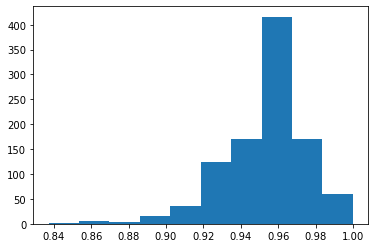


95.0% Confidence Interval: Accuracy 90.21% to 98.88%


In [9]:
# configure bootstrap
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

n_iterations = 1000
n_size = int(len(iris) * 0.50)
# run bootstrap
stats = list()
for i in range(n_iterations):
    # prepare train and test sets
    train = resample(iris.values, n_samples=n_size)
    test = np.array([x for x in iris.values if x.tolist() not in train.tolist()])
    # fit model
    model = LogisticRegression(multi_class='multinomial',
                            solver='newton-cg',random_state=100,
                            max_iter=1000)
    model.fit(train[:,:-1], train[:,-1])
    # evaluate model
    predictions = model.predict(test[:,:-1])
    score = accuracy_score(test[:,-1], predictions)
    #print(score)
    stats.append(score)
# plot scores
plt.hist(stats)
plt.show()
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('\n{}% Confidence Interval: Accuracy {}% to {}%'.format(alpha*100,round(lower*100,2),round(upper*100,2)))